In [ ]:
import torch
from torch_snippets import *
import os
import collections
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
base_dir = "6"
folder =  "bus-trucks"



bus_trucks_dir = os.path.join(base_dir, folder)

In [ ]:
os.listdir(bus_trucks_dir)

In [ ]:
image_root = os.path.join(bus_trucks_dir, "images", "images")

In [ ]:
df_raw_path = os.path.join(bus_trucks_dir, "df.csv")

In [ ]:
df_raw = pd.read_csv(df_raw_path)

In [ ]:
df_raw.head(1)

In [ ]:
df = df_raw.copy()

In [ ]:
# df[df['ImageID'].isin(df['ImageID'].unique().tolist())]
df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

In [ ]:
df_raw

In [ ]:
label2target = {l: t+1 for t,l in enumerate(df_raw['LabelName'].unique())}

In [ ]:
label2target

In [ ]:
label2target['background'] = 0

In [ ]:
target2label = {t:l for l,t in label2target.items()}

In [ ]:
target2label

In [ ]:
background_class = label2target['background']

In [ ]:
background_class

In [ ]:
num_classes = len(label2target)

In [ ]:
num_classes

#### Prepare the dataset

In [ ]:
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229 , 0.224, 0.225]
)

In [ ]:
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [ ]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

In [ ]:
class OpenDataset(Dataset):
    w, h = 300, 300
    def __init__(self, df , image_dir = image_root ):
        self.df = df
        self.image_dir = image_dir
        self.files = Glob(os.path.join(image_dir,"*.jpg"))
        self.image_info = self.df['ImageID'].unique()
        
        print(len(self.image_info))
        
    def __len__(self):
        return len(self.image_info)
    
    
    def __getitem__(self, ix):
        
        image_id = self.image_info[ix]
        image_path = find(image_id, self.files)
        
        img = Image.open(image_path).convert("RGB")
        img = np.array(img.resize(size=(self.w,self.h), resample=Image.BILINEAR))/255.
        
        
        data = self.df[self.df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()  ## list of labels in this image
        
        data = data[['XMin','YMin','XMax','YMax']].values ## bbox coordinates
        
        
        ## rescaling bboxes
        data[:,[0,2]] *= self.w 
        data[:,[1,3]] *= self.h 
        
        ## list of scaled back bounding boxes
        boxes = data.astype(np.uint32).tolist()
        
        return img, boxes, labels
    
    
    
        
    def collate_fn(self, batch):
        #print("in")
        images, boxes, labels =[], [], []
        
        
        # ## pushing everything to gpu
        for item in batch:
            
            img, image_boxes, image_labels = item
            
            #print(img)
            img = preprocess_img(img)[None] # applying normalization parallely on all images, adding batch size dimension
            
            #print(img)
            images.append(img) # adding in images list
            
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.)  ## scaling according to 300*300 image
            
            #labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
            
        images = torch.cat(images).to(device)  ## pushing to GPU
        return images, boxes, labels
        
 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
trn_ids, val_ids = train_test_split(df_raw.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df_raw[df_raw['ImageID'].isin(trn_ids)], df_raw[df_raw['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

In [ ]:
train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)


In [ ]:
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)


test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [ ]:
train_loader

In [ ]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    #N = len()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    
    loss = criterion(_regr, _clss, boxes, labels)  # Multi box loss
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    return loss    

In [ ]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    
    loss = criterion(_regr, _clss, boxes, labels)
    
    return loss
    


In [ ]:
%cd 7

In [ ]:
!git clone https://github.com/sizhky/ssd-utils/

In [ ]:
%cd ssd-utils

In [ ]:
from model import SSD300, MultiBoxLoss
from detect import *

In [ ]:
n_epochs = 3


model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)


log = Report(n_epochs=n_epochs)
log_to_print = 5




In [ ]:
%cd ..

In [ ]:
%cd ..

In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion=criterion, optimizer=optimizer)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), end='\r')
         
    
      

100%|██████████| 104/104 [00:00<00:00, 327.11it/s]


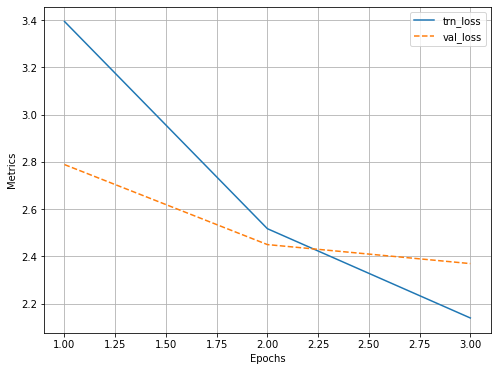

In [201]:
log.plot_epochs()

In [ ]:
## Inferencing

In [202]:
files = Glob(os.path.join(image_root, "*.jpg"))

In [206]:
index = np.random.choice(len(files))

In [214]:
image_id = df_raw.ImageID.values[index]

In [216]:
image_path = find(image_id, files)

In [217]:
image_path

» 6\bus-trucks\images\images\6cfd6e990bea9513.jpg

In [218]:
img = Image.open(image_path, mode='r')

In [220]:
detect?

Signature:
detect(
    original_image,
    model,
    min_score,
    max_overlap,
    top_k,
    device,
    suppress=None,
)
Docstring: <no docstring>
File:      c:\users\rachi\desktop\inueuron\fsds\books\modern-computer-vision-with-pytorch\7\ssd-utils\detect.py
Type:      function


In [221]:
bbs, labels, scores = detect(img, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)

In [225]:
target2label

{1: 'Bus', 2: 'Truck', 0: 'background'}

In [226]:
labels

tensor[1] i64 cuda:0 [1]

In [229]:
labels = [target2label[c.item()] for c in labels]
label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]

In [230]:
label_with_conf

['Bus @ 1.00']

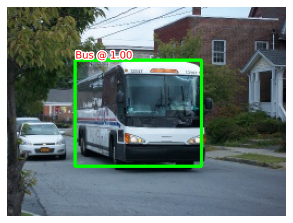

In [231]:
show(img, bbs=bbs, texts=label_with_conf, text_sz=10)

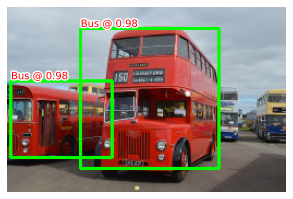

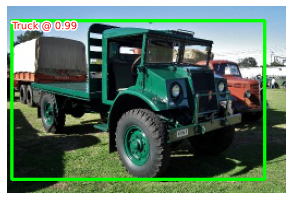

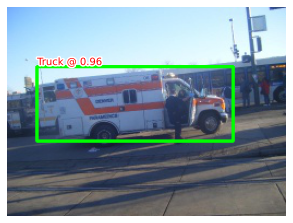

In [245]:
#### inferencing multiple time





for _ in range(3):
    index = np.random.choice(len(files))
    image_id = df_raw.ImageID.values[index]
    image_path = find(image_id, files)
    img = Image.open(image_path, mode='r')
    bbs, labels, scores = detect(img, model, min_score=0.8, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    show(img, bbs=bbs, texts=label_with_conf, text_sz=10)
    
    
    
    